In [1]:
import gymnasium as gym
from gymnasium.spaces import Discrete, Box, Dict, Tuple, MultiBinary, MultiDiscrete

import numpy as np
import matplotlib.pyplot as plt

from stable_baselines3 import PPO
from stable_baselines3 import A2C
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_checker import check_env

In [2]:
from ipywidgets import IntProgress
from IPython.display import display

In [3]:
from cost_calculator_factory import CostCalculatorFactory
from multibinary_converter import MultiBinaryConverter
from multidiscrete_converter import MultiDiscreteConverter
from fitness_calculator import FitnessCalculator

In [4]:
dtype = np.int64

In [5]:
l = 1
n = 5
m = 4
k = 3

In [6]:
T = np.array([
    [  1,   0,   0,   0],
    [0.5, 0.5,   0,   0],
    [  0, 0.5, 0.5,   0],
    [  0,   0, 0.5, 0.5],
    [  0,   0,   0,   1]
])

In [7]:
D = np.array([
    [0, 0, 1, 0],
    [0, 0, 1, 1],
    [0, 0, 0, 0],
    [0, 0, 0, 0]
])

In [8]:
C = np.array([
    [1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1]
])

In [9]:
E = np.array([
    [1, 0, 0, 0, 0]
])

In [10]:
class MultiBinaryConfig:
    def __init__(self, m, k, dtype):
        self.m = m
        self.k = k
        self.dtype = dtype
        
        self.count = m * k
        self.action_space = MultiBinary(self.count)
        self.observation_space = Box(low=0, high=1, shape=(self.count, ), dtype=dtype)

In [11]:
class MultiDiscreteConfig:
    def __init__(self, m, k, dtype):
        self.m = m
        self.k = k
        self.dtype = dtype

        self.count = m
        self.action_space = MultiDiscrete([k for i in range(m)])
        self.observation_space = Box(low=0, high=k, shape=(m, ), dtype=self.dtype)

In [12]:
class Graphic:
    def __init__(self):
        self.values = []

    def append_value(self, value):
        self.values.append(value)

    def show(self):
        x = range(len(self.values))
        y = self.values
        plt.axis([0, len(self.values), -1, 3])
        plt.plot(x, y)

In [13]:
class OptimisationTaskEnv(gym.Env):
    def __init__(self, config, fitness_calculator, progress, graphic):
        super(OptimisationTaskEnv, self).__init__()
        self.fitness_calculator = fitness_calculator
        self.progress = progress
        self.graphic = graphic
        self.dtype = config.dtype
        self.action_space = config.action_space
        self.observation_space = config.observation_space
        self.default_observation = np.zeros(config.count, dtype=self.dtype)
        self.observation = self.default_observation
        self.info = {}

    def step(self, action):
        self.observation = np.array(action).astype(self.dtype)

        fitness = self.fitness_calculator.calculate(self.observation)
        self.graphic.append_value(fitness)

        truncated = False
        terminated = False

        self.progress.value += 1
        return self.observation, float(fitness), terminated, truncated, self.info
    
    def reset(self, seed=None, options=None):
        self.observation = self.default_observation
        return (self.observation, self.info)

In [14]:
def learn(env, progress):
    check_env(env)
    # policies: MlpPolicy
    # algorithms: A2C, PPO
    model = A2C("MlpPolicy", env)
    display(progress)
    model.learn(total_timesteps=progress.max)
    observation = model.env.envs[0].env.observation
    return observation

In [15]:
total_timesteps = 10000

In [16]:
cost_calculator_factory = CostCalculatorFactory(T, D, C, E)

In [17]:
# MultiBinary

In [18]:
multibinary_config = MultiBinaryConfig(m, k, dtype)

In [19]:
multibinary_converter = MultiBinaryConverter(m, k)
multibinary_fitness_calcultor = FitnessCalculator(cost_calculator_factory, multibinary_converter)

In [20]:
multibinary_progress = IntProgress(min=0, max=total_timesteps, value=0, description='multibinary', bar_style='success')
multibinary_graphic = Graphic()
multibinary_optimisation_task_env = OptimisationTaskEnv(multibinary_config, multibinary_fitness_calcultor, multibinary_progress, multibinary_graphic)

In [21]:
learn(multibinary_optimisation_task_env, multibinary_progress)

IntProgress(value=11, bar_style='success', description='multibinary', max=10000)

array([1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0])

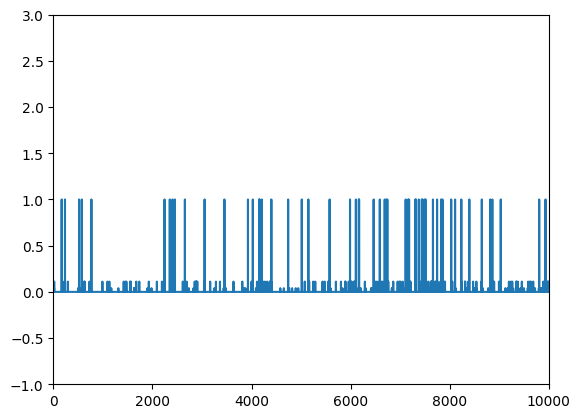

In [22]:
multibinary_graphic.show()

In [23]:
# MultiDiscrete

In [24]:
multidiscrete_config = MultiDiscreteConfig(m, k, dtype)

In [25]:
multidiscrete_converter = MultiDiscreteConverter(m, k)
multidiscrete_fitness_calculator = FitnessCalculator(cost_calculator_factory, multidiscrete_converter)

In [26]:
multidiscrete_progress = IntProgress(min=0, max=total_timesteps, value=0, description='multidiscrete', bar_style='success')
multidiscrete_graphic = Graphic()
multidiscrete_optimisation_task_env = OptimisationTaskEnv(multidiscrete_config, multidiscrete_fitness_calculator, multidiscrete_progress, multidiscrete_graphic)

In [27]:
learn(multidiscrete_optimisation_task_env, multidiscrete_progress)

IntProgress(value=11, bar_style='success', description='multidiscrete', max=10000)

array([2, 1, 2, 1])

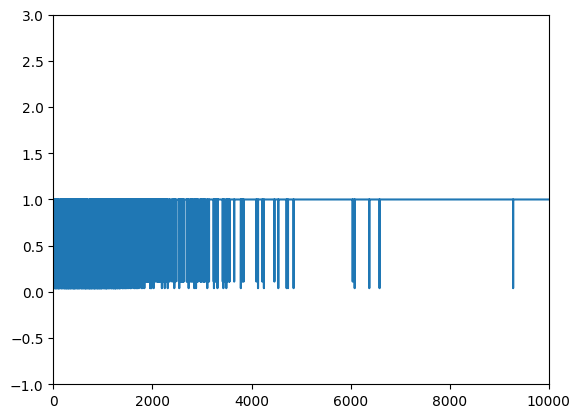

In [28]:
multidiscrete_graphic.show()